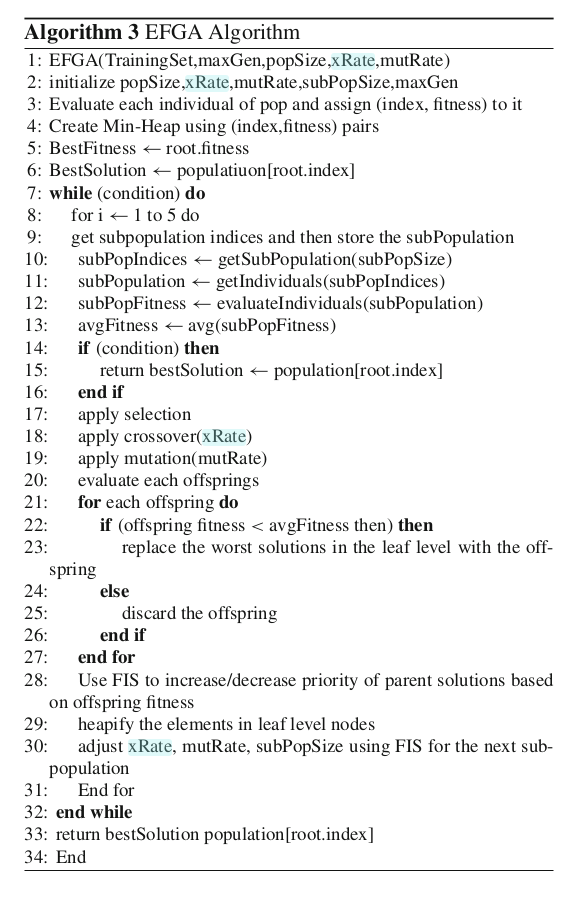

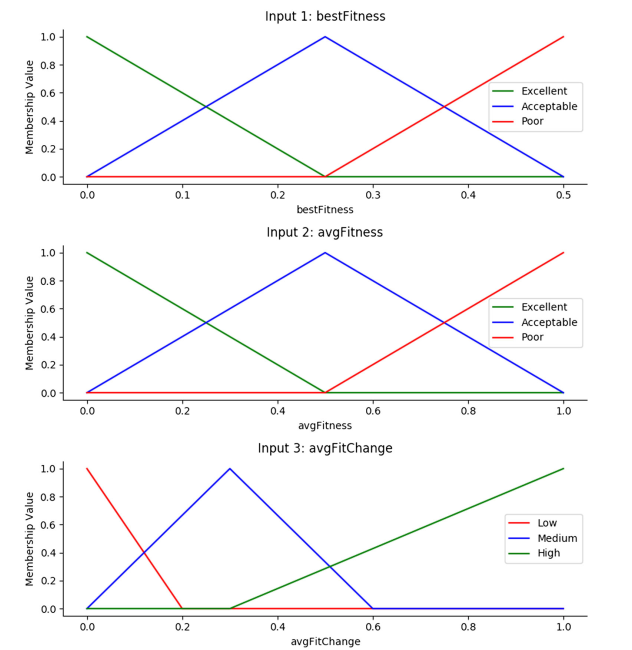
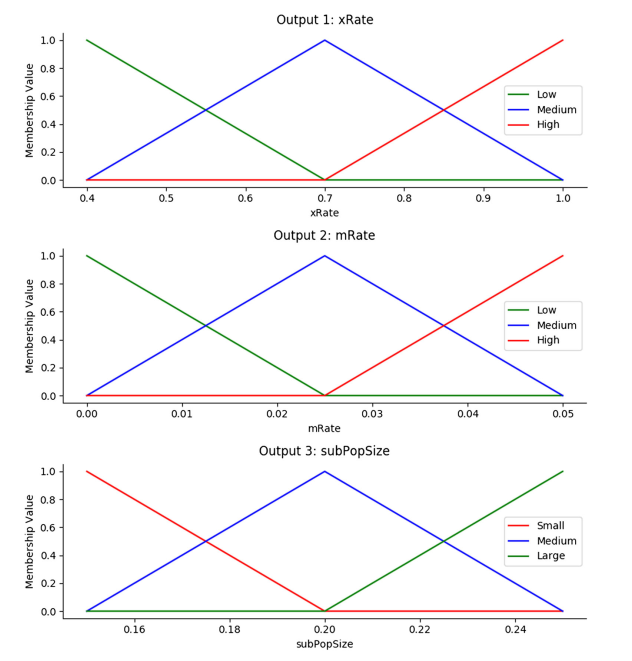

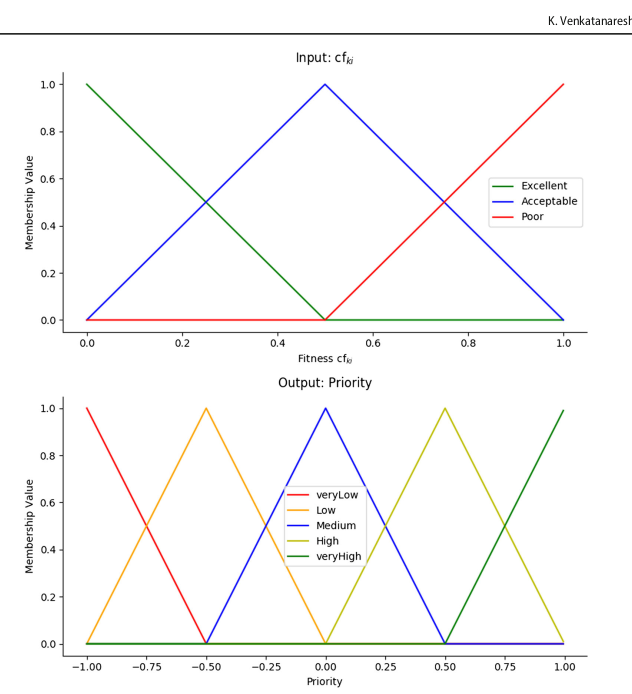


TODO: 
1) Implement minheap and test it - Done
2) Minimization relative fitness value (let's say that we have error, how do we calculate fitness value) - Done
3) Implement fuzzy sets for: bestFitness, xRate,mutRate, subPopSize, priority: very low-very high - Done
4) Implement fuzzy rules. - Done. 
5) Implement crossover
6) Implement mutation


In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


from src.common.experiment_runners import run_experiments_efga, run_experiments_gendered
from src.common.visualization import visualize_efga, visualize_gendered
from src.common.fitness import griewank

In [6]:
import numpy as np



## Schwefel function

### EFGA

In [2]:
output_params = 'log/schwefel_efga_params.json'
output_experiment_logs = 'log/schwefel_experiment_efga_logs.csv'
experiment_logs, params = run_experiments_efga(n_experiments=5, epochs=500)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)


100%|██████████| 5/5 [05:39<00:00, 67.81s/it]


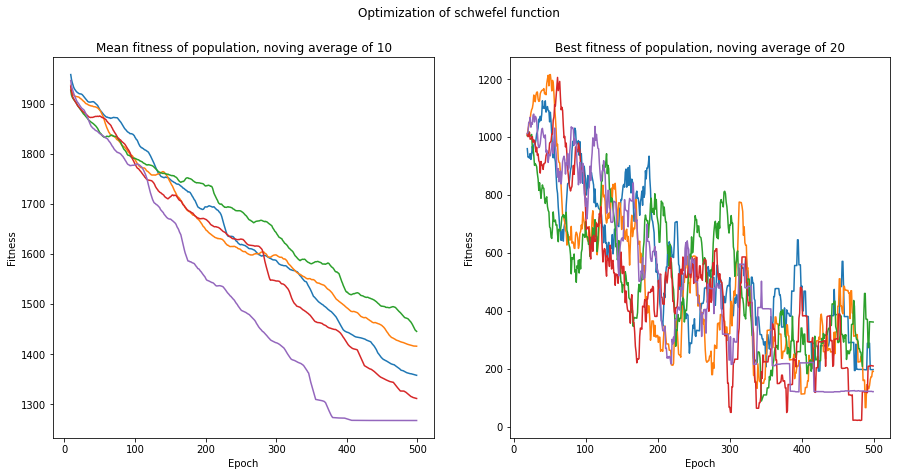

In [3]:
visualize_efga(experiment_logs, windowsize_best=20, function_name='schwefel function')


In [4]:
experiment_logs.groupby('seed').first()['ncalls'].mean(), experiment_logs.groupby('seed').first()['ncalls'].median()

(33449.6, 33166.0)

### Gendered selection

In [2]:
output_params = 'log/schwefel_gendered_params.json'
output_experiment_logs = 'log/schwefel_gendered_logs.csv'
experiment_logs, params = run_experiments_gendered(n_experiments=5, epochs=100, population_scale=500, mutation_scale=.5, N=150)

with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)
experiment_logs, params

100%|██████████| 5/5 [02:21<00:00, 28.31s/it]


(    avg_fitness  best_fitness  population_size  epoch  ncalls  seed
 0   2024.216906    951.072796              172      0   17209     0
 1   2011.799454   1018.063638              197      1   17209     0
 2   2006.454469    973.351884              222      2   17209     0
 3   1997.146729    891.579314              239      3   17209     0
 4   1945.886689    898.543841              249      4   17209     0
 ..          ...           ...              ...    ...     ...   ...
 95   613.386982    428.512098               98     95   16203     4
 96   609.186307    428.356089              103     96   16203     4
 97   606.733567    426.399172              102     97   16203     4
 98   589.059540    425.931230               98     98   16203     4
 99   585.844980    425.982779               89     99   16203     4
 
 [500 rows x 6 columns],
 {'n_experiments': 5,
  'fitness_fn': 'schwefel',
  'population_scale': 500,
  'mutation_scale': 0.5,
  'N': 150,
  'epochs': 100})

In [2]:
experiment_logs, params = pd.read_csv('log/schwefel_gendered_logs.csv'), json.load(open('log/schwefel_gendered_params.json', 'r'))

In [3]:
experiment_logs.seed.unique()

array([0, 1, 2, 3, 4])

In [4]:
experiment_logs[experiment_logs.seed == 4]

,Unnamed: 0,avg_fitness,best_fitness,population_size,epoch,ncalls,seed
400,0,2160.568346,1056.730868,174,0,16203,4
401,1,2121.469544,956.676724,201,1,16203,4
402,2,2069.253584,937.724305,231,2,16203,4
403,3,2012.076274,930.504316,251,3,16203,4
404,4,1992.760353,938.034472,258,4,16203,4
...,...,...,...,...,...,...,...
495,95,613.386982,428.512098,98,95,16203,4
496,96,609.186307,428.356089,103,96,16203,4
497,97,606.733567,426.399172,102,97,16203,4
498,98,589.059540,425.931230,98,98,16203,4


wqehwe
wqehwe
wqehwe
wqehwe
wqehwe


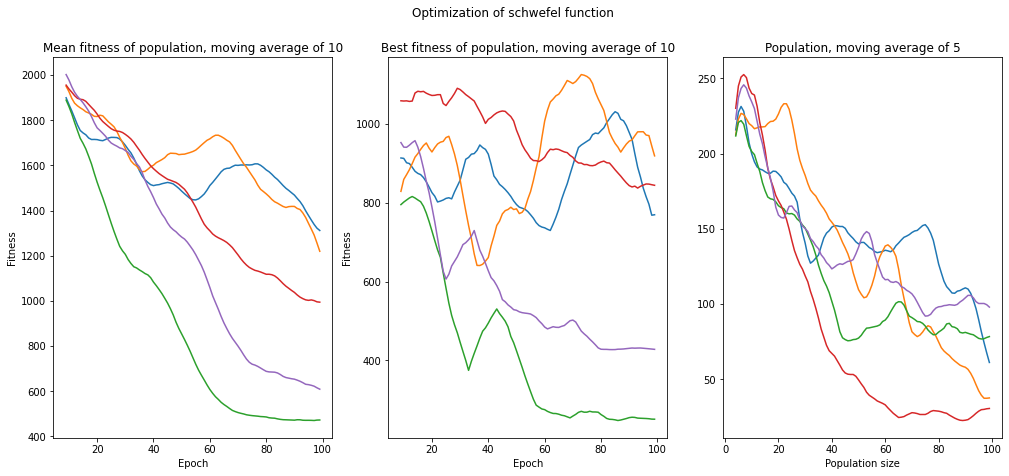

In [5]:
visualize_gendered(history=experiment_logs, function_name='schwefel function')

In [10]:
experiment_logs.groupby('seed').first()['ncalls'].mean(), experiment_logs.groupby('seed').first()['ncalls'].median()

(14648.6, 15986.0)

## Griewank function

### EFGA

In [2]:
output_params = 'log/griewank_efga_params.json'
output_experiment_logs = 'log/griewank_experiment_efga_logs.csv'
experiment_logs, params = run_experiments_efga(n_experiments=5, epochs=500, fitness_fn=griewank, population_scale=600, mutation_scale=.2)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)

100%|██████████| 5/5 [04:24<00:00, 52.85s/it]


In [3]:
experiment_logs, params = pd.read_csv('log/griewank_experiment_efga_logs.csv'), json.load(open('log/griewank_efga_params.json', 'r'))

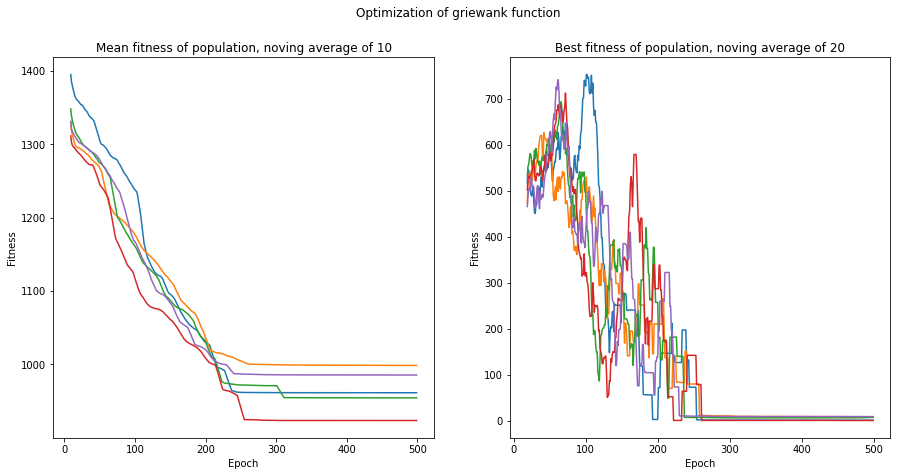

(27773.2, 27812.0)

In [4]:
visualize_efga(experiment_logs, windowsize_best=20, function_name='griewank function')
experiment_logs.groupby('seed').first()['ncalls'].mean(), experiment_logs.groupby('seed').first()['ncalls'].median()


### Gendered selection

In [5]:
output_params = 'log/griewank_gendered_params.json'
output_experiment_logs = 'log/griewank_experiment_gendered_logs.csv'
experiment_logs, params = run_experiments_gendered(n_experiments=5, epochs=100, population_scale=600, mutation_scale=.5, N=150, fitness_fn=griewank)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)

100%|██████████| 5/5 [02:34<00:00, 30.92s/it]


wqehwe
wqehwe
wqehwe
wqehwe
wqehwe


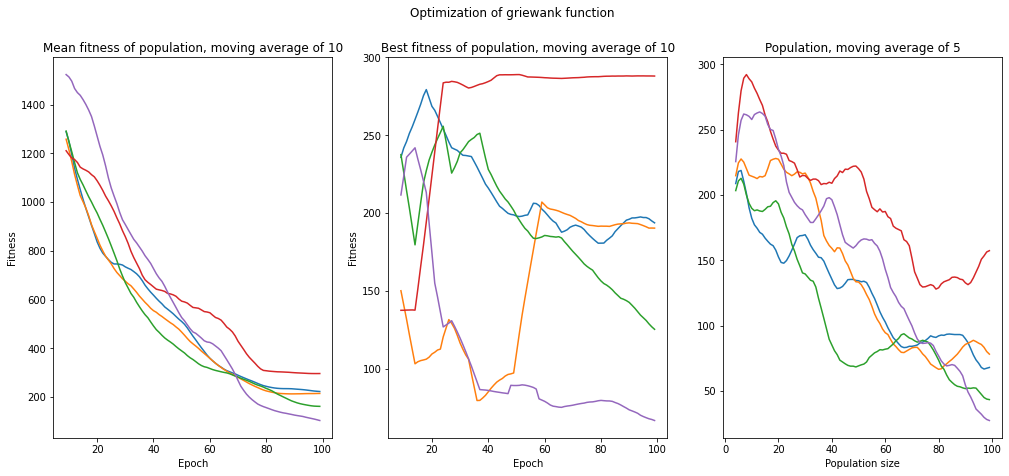

In [6]:
visualize_gendered(history=experiment_logs, function_name='griewank function')

## Rastrigin function

### EFGA

### Gendered selection

## Ackley function

### EFGA

### Gendered selection